In [36]:
import os
from zipfile import ZipFile

zip_path = './resources/lfw-deepfunneled.zip'
extract_path = './resources/lfw'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")
# Now you can list the directories or work with the files
print(os.listdir(extract_path))


Files extracted to: ./resources/lfw
['lfw-deepfunneled', 'lfw_allnames.csv', 'matchpairsDevTest.csv', 'matchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'mismatchpairsDevTrain.csv', 'pairs.csv', 'people.csv', 'peopleDevTest.csv', 'peopleDevTrain.csv']


In [37]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "./resources/lfw/lfw-deepfunneled"

In [38]:

# Initialize lists to hold the names and image counts
names = []
image_counts = []

# Iterate through each directory (individual's name) in the dataset path
for name in os.listdir(dataset_path):
    # Construct the path to the individual's directory
    individual_path = os.path.join(dataset_path, name)
    # Ensure the path is indeed a directory
    if os.path.isdir(individual_path):
        # Add the individual's name to the names list
        names.append(name)
        # Count the number of images in the individual's directory and add to the image_counts list
        image_counts.append(len([img for img in os.listdir(individual_path) if img.endswith('.jpg')]))

# Create a DataFrame from the names and image counts
lfw_allnames = pd.DataFrame({
    'name': names,
    'images': image_counts
})

# Optionally, sort the DataFrame by name or image count
lfw_allnames.sort_values(by='name', inplace=True)

# Path to save the updated CSV file
updated_csv_path = "./resources/lfw/lfw_allnames.csv"

# Save the DataFrame to a new CSV file
lfw_allnames.to_csv(updated_csv_path, index=False)

print("Updated CSV file saved to:", updated_csv_path)


Updated CSV file saved to: ./resources/lfw/lfw_allnames.csv


In [39]:
# Data read-in and cleaning
lfw_allnames = pd.read_csv("./resources/lfw/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("./resources/lfw/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("./resources/lfw/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("./resources/lfw/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("./resources/lfw/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("./resources/lfw/pairs.csv")

# Tidy pairs data:
pairs = pairs.rename(columns={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2", axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("./resources/lfw/people.csv")

# Remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("./resources/lfw/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("./resources/lfw/peopleDevTrain.csv")


In [40]:
print("Summary:")
print("There are " +
      str(lfw_allnames.shape[0]) +
      " unique celebrities in the entire dataset, of whom " +
      str(sum(lfw_allnames.images > 1)) +
      " are represented by multiple images. The entire number of images available is " +
      str(sum(lfw_allnames.images)) +
      ". The most represented celebrity is " +
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) +
      ", with " +
      str(max(lfw_allnames.images)) +
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


In [41]:
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))


855
852


C:\Users\Alexis\AppData\Local\Temp\ipykernel_3688\234548390.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_3688\234548390.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
C:\Users\Alexis\AppData\Local\Temp\ipykernel_3688\234548390.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


In [42]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "./resources/lfw/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


<Axes: >

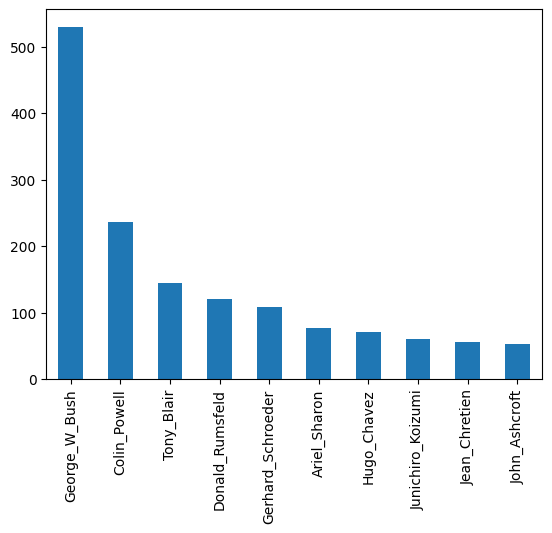

In [43]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [44]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


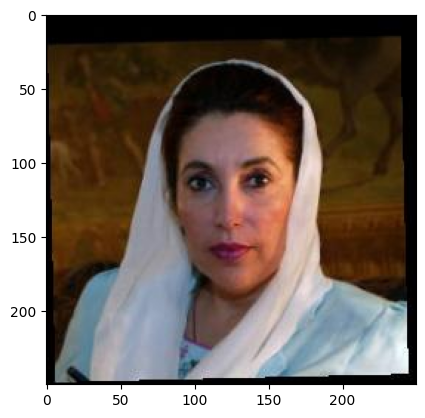

In [45]:
im = Image.open("./resources/lfw/lfw-deepfunneled/" + str(lfw_train.image_path[10]))
plt.imshow(im)

1/1 [==============================] - 0s 168ms/step


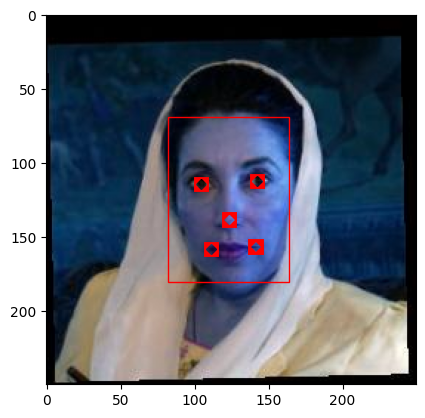

In [46]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("./resources/lfw/lfw-deepfunneled/" + str(lfw_train.image_path[10]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

In [47]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [48]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [49]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Activation

def build_bush_classifier():
    model = Sequential()

    # Block 1
    model.add(ZeroPadding2D((1,1), input_shape=(250, 250, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #Block2
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #Block3
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #Block 4
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # Block 5
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # Custom Classifier Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Now we build the model
bush_classifier = build_bush_classifier()


In [50]:
bush_classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_26 (ZeroPad  (None, 252, 252, 3)       0         
 ding2D)                                                         
                                                                 
 conv2d_74 (Conv2D)          (None, 250, 250, 64)      1792      
                                                                 
 zero_padding2d_27 (ZeroPad  (None, 252, 252, 64)      0         
 ding2D)                                                         
                                                                 
 conv2d_75 (Conv2D)          (None, 250, 250, 64)      36928     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 125, 125, 64)      0         
 ng2D)                                                           
                                                      

In [57]:
import os

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('./resources/',dir_name)):
            os.mkdir(os.path.join('./resources/',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('./resources/',dir_name,data_type)):
            os.mkdir(os.path.join('./resources/',dir_name,data_type))
        path_from = os.path.join('./resources/lfw/lfw-deepfunneled/',image)
        path_to = os.path.join('./resources/',dir_name,data_type)
        shutil.copy(path_from, path_to)
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))


In [58]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")


Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [61]:
import keras.preprocessing.image

# Set up the image data generators
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

# Prepare the data sets
Bush_training_set = train_datagen.flow_from_directory('./resources/Bush_train/',
                                                      target_size = (250, 250),
                                                      batch_size = 32,
                                                      class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('./resources/Bush_val/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('./resources/Bush_test/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')


Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [62]:
bush_classifier.fit(Bush_training_set,
                                             # set steps per epoch equal to the number of training images
                                             steps_per_epoch = 678/32,
                                             epochs = 10,
                                             validation_data = Bush_val_set,
                                             validation_steps = 170/32)

C:\Users\Alexis\AppData\Local\Temp\ipykernel_3688\2232760407.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  bush_classifier.fit_generator(Bush_training_set,


Epoch 1/10
17/21 [=======================>......] - ETA: 5:01 - loss: 0.7170 - accuracy: 0.5039

KeyboardInterrupt: 